In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit, try_to_timestamp, row_number
from pyspark.sql.window import Window

spark = SparkSession.builder \
    .config("spark.driver.memory", "12g") \
    .appName("Apache Jira Issues") \
    .getOrCreate()

spark.catalog.clearCache()

In [2]:
issues = spark.read \
    .option("maxColumns", 1000) \
    .csv("./apache/issues_cleaned.csv", header=True, inferSchema=True)

issues = issues \
    .withColumn("created_at", try_to_timestamp(col("created_at"))) \
    .withColumn("updated_at", try_to_timestamp(col("updated_at"))) \
    .withColumn("resolved_at", try_to_timestamp(col("resolved_at")))

issues.printSchema()

root
 |-- id: string (nullable = true)
 |-- key: string (nullable = true)
 |-- project_id: string (nullable = true)
 |-- project_key: string (nullable = true)
 |-- project_name: string (nullable = true)
 |-- project_category: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- updated_at: timestamp (nullable = true)
 |-- resolved_at: timestamp (nullable = true)
 |-- creator: string (nullable = true)
 |-- assignee: string (nullable = true)
 |-- reporter: string (nullable = true)
 |-- issue_type: string (nullable = true)
 |-- status_name: string (nullable = true)
 |-- status_category: string (nullable = true)
 |-- priority: string (nullable = true)
 |-- resolution: string (nullable = true)
 |-- votes: string (nullable = true)
 |-- watches: string (nullable = true)



In [3]:
changelog_issues = spark.read \
    .option("maxColumns", 1000) \
    .csv("./apache/changelog_issues.csv", header=True, inferSchema=True)

# changelog_issues = changelog_issues \
#     .withColumn("first_change_at", try_to_timestamp(col("first_change_at"))) \
#     .withColumn("last_change_at", try_to_timestamp(col("last_change_at")))

changelog_issues.printSchema()

root
 |-- id: string (nullable = true)
 |-- time_spent: integer (nullable = true)
 |-- time_estimate: integer (nullable = true)
 |-- original_estimate: integer (nullable = true)
 |-- total_changes: integer (nullable = true)
 |-- status_changes: integer (nullable = true)
 |-- priority_changes: integer (nullable = true)
 |-- assignee_changes: integer (nullable = true)
 |-- issuetype_changes: integer (nullable = true)
 |-- resolution_changes: integer (nullable = true)
 |-- timeestimate_changes: integer (nullable = true)
 |-- description_changes: integer (nullable = true)
 |-- fixversion_changes: integer (nullable = true)
 |-- reopen_times: integer (nullable = true)
 |-- unique_authors: integer (nullable = true)



In [4]:
# merge issues with changelog_issues, by id
issues_merged = issues.join(changelog_issues, on="id", how="left")

In [5]:
# try to cast id to integer (using try_cast), if fails, drop the rows
issues_merged = issues_merged.withColumn(
    "id",
    when(col("id").isNull(), None).otherwise(col("id").try_cast("integer"))
)
# drop rows with null id
issues_merged = issues_merged.dropna(subset=["id"])

# try to cast project_id to integer, if fails, drop the rows
issues_merged = issues_merged.withColumn(
    "project_id",
    when(col("project_id").isNull(), None).otherwise(col("project_id").try_cast("integer"))
)
# drop rows with null project_id
issues_merged = issues_merged.dropna(subset=["project_id"])

In [6]:
count_columns = [
    "total_changes",
    "status_changes",
    "priority_changes",
    "assignee_changes",
    "issuetype_changes",
    "resolution_changes",
    "timeestimate_changes",
    "description_changes",
    "fixversion_changes",
    "reopen_times", 
    "unique_authors"
]

# set count columns 0 if they are null
for col_name in count_columns:
    issues_merged = issues_merged.withColumn(
        col_name,
        when(col(col_name).isNull(), 0).otherwise(col(col_name).cast("integer"))
    )

In [7]:
# change units of time_spent, time_estimate, and original estimate from seconds to hours
issues_merged = issues_merged.withColumn(
    "time_spent",
    when(col("time_spent").isNull(), lit(0)).otherwise(col("time_spent") / 3600)
).withColumn(
    "time_estimate",
    when(col("time_estimate").isNull(), lit(0)).otherwise(col("time_estimate") / 3600)
).withColumn(
    "original_estimate",
    when(col("original_estimate").isNull(), lit(0)).otherwise(col("original_estimate") / 3600)
)

In [8]:
issues_merged.printSchema()

root
 |-- id: integer (nullable = true)
 |-- key: string (nullable = true)
 |-- project_id: integer (nullable = true)
 |-- project_key: string (nullable = true)
 |-- project_name: string (nullable = true)
 |-- project_category: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- updated_at: timestamp (nullable = true)
 |-- resolved_at: timestamp (nullable = true)
 |-- creator: string (nullable = true)
 |-- assignee: string (nullable = true)
 |-- reporter: string (nullable = true)
 |-- issue_type: string (nullable = true)
 |-- status_name: string (nullable = true)
 |-- status_category: string (nullable = true)
 |-- priority: string (nullable = true)
 |-- resolution: string (nullable = true)
 |-- votes: string (nullable = true)
 |-- watches: string (nullable = true)
 |-- time_spent: double (nullable = true)
 |-- time_estimate: double (nullable = true)
 |-- original_estimate: double (nullable = true)
 |-- total_changes: integer (nullable = true)
 |-- status_changes:

In [9]:
# issues_merged.show(5, truncate=False)

In [10]:
# new features
# lifespan: created_at to resolved_at (in days)
# workspan: created_at to updated_at (in days)
# change density: total_changes / lifespan
# reassignment rate: assignee_changes / total_changes
# description edit rate: description_changes / total_changes
# author churn: unique_authors / total_changes
# fix version change rate: fixversion_changes / total_changes
# resolution change rate: resolution_changes / total_changes
# status change rate: status_changes / total_changes
# priority change rate: priority_changes / total_changes
# issue type change rate: issuetype_changes / total_changes
# has time fields: time_spent and original_estimate is not equal to 0

issues_merged = issues_merged.withColumn(
    "lifespan",
    (col("resolved_at").cast("long") - col("created_at").cast("long")) / 86400
).withColumn(
    "workspan",
    (col("updated_at").cast("long") - col("created_at").cast("long")) / 86400
).withColumn(
    "change_density",
    when(col("lifespan") > 0, col("total_changes") / col("lifespan")).otherwise(lit(0))
).withColumn(
    "reassignment_rate",
    when(col("total_changes") > 0, col("assignee_changes") / col("total_changes")).otherwise(lit(0))
).withColumn(
    "description_edit_rate",
    when(col("total_changes") > 0, col("description_changes") / col("total_changes")).otherwise(lit(0))
).withColumn(
    "author_churn",
    when(col("total_changes") > 0, col("unique_authors") / col("total_changes")).otherwise(lit(0))
).withColumn(
    "fix_version_change_rate",
    when(col("total_changes") > 0, col("fixversion_changes") / col("total_changes")).otherwise(lit(0))
).withColumn(
    "resolution_change_rate",
    when(col("total_changes") > 0, col("resolution_changes") / col("total_changes")).otherwise(lit(0))
).withColumn(
    "status_change_rate",
    when(col("total_changes") > 0, col("status_changes") / col("total_changes")).otherwise(lit(0))
).withColumn(
    "priority_change_rate",
    when(col("total_changes") > 0, col("priority_changes") / col("total_changes")).otherwise(lit(0))
).withColumn(
    "issue_type_change_rate",
    when(col("total_changes") > 0, col("issuetype_changes") / col("total_changes")).otherwise(lit(0))
).withColumn(
    "has_time_fields",
    when(
        (col("time_spent") != 0) | (col("original_estimate") != 0), lit(True)
    ).otherwise(lit(False))
)

In [11]:
# new features for issues_with_time:
# - delay: (timespent - original_estimate)
# - delay_ratio: delay / original_estimate (if original_estimate > 0)
# - time_estimate_change_rate: timeestimate_changes / total_changes (if total_changes > 0)

# apply this only for rows with has_time_fields = True
issues_merged = issues_merged.withColumn(
    "delay",
    when(
        col("has_time_fields"),
        (col("time_spent").cast("long") - col("original_estimate").cast("long"))
    ).otherwise(lit(None))
).withColumn(
    "delay_ratio",
    when(
        (col("has_time_fields") & (col("original_estimate") > 0)),
        col("delay") / col("original_estimate")
    ).otherwise(lit(None))
).withColumn(
    "time_estimate_change_rate",
    when(
        (col("has_time_fields") & (col("total_changes") > 0)),
        col("timeestimate_changes") / col("total_changes")
    ).otherwise(lit(0))
)

In [12]:
# issues_merged.filter(col("has_time_fields")).show(5, truncate=False)

In [13]:
# issues_merged.filter(col("time_spent").isNotNull() & col("original_estimate").isNotNull()).show(5, truncate=False)

In [14]:
# project-level aggregation

# features:
# - total reopened: sum of reopen_times
# - average lifespan: average of lifespan
# - average workspan: average of workspan
# - average change density: average of change_density
# - average reassignment rate: average of reassignment_rate
# - average description edit rate: average of description_edit_rate
# - average author churn: average of author_churn
# - average fix version change rate: average of fix_version_change_rate
# - average time estimate change rate: average of time_estimate_change_rate
# - average resolution change rate: average of resolution_change_rate
# - average status change rate: average of status_change_rate
# - average priority change rate: average of priority_change_rate
# - average issue type change rate: average of issue_type_change_rate
# - total changes: sum of total_changes
# - total issues: count of issues
# - total members: count of unique assignees and reporters, and total members including both assignees and reporters
# - total issues with resolution = <each> (e.g., "Fixed", "Won't Fix", etc.): count of issues with resolution not null
# - total issues with status = <each> (e.g., "Open", "Closed", etc.): count of issues with status not null
# - total issues with priority = <each> (e.g., "Low", "Medium", "High"): count of issues with priority not null
# - total issues with issuetype = <each> (e.g., "Bug", "Task", etc.): count of issues with issuetype not null
# - total issues with issuetype = "Bug" and priority = "High": count of high priority bugs
# - has_time_fields: True if at least one issue has time fields not null

from pyspark.sql import functions as F

resolution_values = issues_merged.select("resolution").distinct().collect()
resolution_counts = {row.resolution: F.sum(when(col("resolution") == row.resolution, 1).otherwise(0)).alias(f"num_resolution_{row.resolution.replace(' ', '_').lower()}")
                     for row in resolution_values if row.resolution is not None}
status_values = issues_merged.select("status_category").distinct().collect()
status_counts = {row.status_category: F.sum(when(col("status_category") == row.status_category, 1).otherwise(0)).alias(f"num_status_{row.status_category.replace(' ', '_').lower()}")
                 for row in status_values if row.status_category is not None}
priority_values = issues_merged.select("priority").distinct().collect()
priority_counts = {row.priority: F.sum(when(col("priority") == row.priority, 1).otherwise(0)).alias(f"num_priority_{row.priority.replace(' ', '_').lower()}")
                    for row in priority_values if row.priority is not None}
issuetype_values = issues_merged.select("issue_type").distinct().collect()
issuetype_counts = {row.issue_type: F.sum(when(col("issue_type") == row.issue_type, 1).otherwise(0)).alias(f"num_issue_type_{row.issue_type.replace(' ', '_').lower()}")
                    for row in issuetype_values if row.issue_type is not None}

projects = issues_merged.groupBy("project_id") \
    .agg(
        # with project key, name and category
        F.first("project_key").alias("project_key"),
        F.first("project_name").alias("project_name"),
        F.first("project_category").alias("project_category"),

        F.sum("reopen_times").alias("total_reopened"),
        F.avg("lifespan").alias("average_lifespan"),
        F.avg("workspan").alias("average_workspan"),
        F.avg("change_density").alias("average_change_density"),
        F.avg("reassignment_rate").alias("average_reassignment_rate"),
        F.avg("description_edit_rate").alias("average_description_edit_rate"),
        F.avg("author_churn").alias("average_author_churn"),
        F.avg("fix_version_change_rate").alias("average_fix_version_change_rate"),
        F.avg("time_estimate_change_rate").alias("average_time_estimate_change_rate"),
        F.avg("resolution_change_rate").alias("average_resolution_change_rate"),
        F.avg("status_change_rate").alias("average_status_change_rate"),
        F.avg("priority_change_rate").alias("average_priority_change_rate"),
        F.avg("issue_type_change_rate").alias("average_issue_type_change_rate"),
        F.sum("total_changes").alias("total_changes"),
        F.countDistinct(col("assignee")).alias("total_assignees"),  # unique assignees
        F.countDistinct(col("reporter")).alias("total_reporters"),  # unique reporters
        F.size(F.array_distinct(F.flatten(F.array(F.collect_set("assignee"), F.collect_set("reporter"))))).alias("total_members"),  # total members (union of assignees and reporters)
        F.countDistinct(col("id")).alias("total_issues"),
        *resolution_counts.values(),
        *status_counts.values(),
        *priority_counts.values(),
        *issuetype_counts.values(),
        F.sum(when((col("issue_type") == "Bug") & (col("priority") == "High"), 1).otherwise(0)).alias("num_high_priority_bugs"),
        # F.max(when(col("has_time_fields"), lit(True)).otherwise(lit(False))).alias("has_time_fields"),

        # time fields related features
        # F.avg(when(col("has_time_fields"), col("time_spent").cast("long"))).alias("average_time_spent"),
        # F.avg(when(col("has_time_fields"), col("original_estimate").cast("long"))).alias("average_original_estimate"),
        # F.avg(when(col("has_time_fields"), col("delay"))).alias("average_delay"),
        # F.avg(when(col("has_time_fields"), col("delay_ratio"))).alias("average_delay_ratio"),
        # F.avg(when(col("has_time_fields"), col("time_estimate_change_rate"))).alias("average_time_estimate_change_rate"),
    )

In [15]:
# projects.show(50, truncate=False)

In [16]:
# filter out corrupted projects: project_key must be all uppercase, alphabet only
projects = projects.filter(col("project_key").rlike("^[A-Z]+$"))

In [17]:
projects.count()

616

Unmatched project name: Stonehenge
	 --> Uncategorized
Unmatched project name: BVal
	 --> Uncategorized
Unmatched project name: Rave
	 --> Uncategorized
Unmatched project name: DeltaSpike
	 --> Uncategorized
Unmatched project name: Syncope
	 --> Uncategorized
Unmatched project name: Hadoop YARN
Unmatched project name: Apache Drill
	 --> Uncategorized
Unmatched project name: BatchEE
	 --> Uncategorized
Unmatched project name: eSCIMo 
	 --> Uncategorized
Unmatched project name: DataFu
	 --> Uncategorized
Unmatched project name: CXF XJC Utils
Unmatched project name: Apache Climate Model Diagnostic Analyzer
	 --> Uncategorized
Unmatched project name: Fineract Cloud Native
Unmatched project name: Apache NetBeans Infra
	 --> Uncategorized
Unmatched project name: Cactus
	 --> Uncategorized
Unmatched project name: James Mailet
Unmatched project name: Aries
	 --> Uncategorized
Unmatched project name: Apache Tomcat Maven Plugin
Unmatched project name: ODF Toolkit
	 --> Uncategorized
Unmatched pr

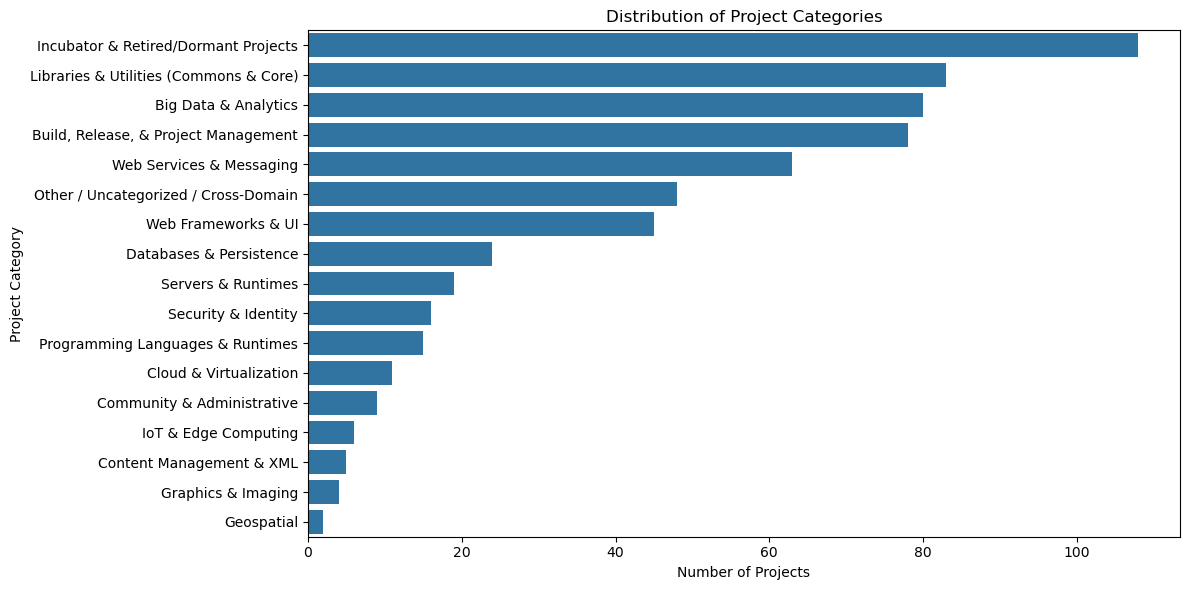

In [ ]:
# categorization is corrupted, let's do it manually
from matplotlib import pyplot as plt
import seaborn as sns
from apache_categorization import project_to_category

df = projects.toPandas()

# Let's create a function to categorize projects by domain
# A dictionary mapping project names to their categories
# This can be built more robustly if the exact mapping logic is complex,
# but for demonstration, we'll map a few directly based on our discussion.
# For projects not explicitly listed here, a lookup based on keywords or
# a default 'Other / Uncategorized' will be used.
from apache_categorization import project_to_category

def categorize_project(project_name):
    """
    Categorizes an Apache project based on predefined mappings.
    """
    # Exact match lookup
    if project_name in project_to_category:
        return project_to_category[project_name]
    
    print("Unmatched project name:", project_name)

    # Handle common patterns for categorization if exact match isn't found
    # This is a simplification; a more robust solution might use regex or NLP
    if 'Commons' in project_name:
        return 'Libraries & Utilities (Commons & Core)'
    if 'Maven' in project_name:
        return 'Build, Release, & Project Management'
    if 'MyFaces' in project_name:
        return 'Web Frameworks & UI'
    if 'Jackrabbit' in project_name:
        return 'Databases & Persistence' # Primarily content repository, which is persistence
    if 'James' in project_name:
        return 'Servers & Runtimes' # Mail server related
    if 'Hadoop' in project_name or 'Hive' in project_name or 'Spark' in project_name or 'Flink' in project_name or 'Kafka' in project_name or 'Solr' in project_name or 'Lucene' in project_name or 'Cassandra' in project_name:
        return 'Big Data & Analytics'
    if 'Axis' in project_name or 'SOAP' in project_name or 'WSS4J' in project_name or 'ActiveMQ' in project_name or 'Qpid' in project_name or 'CXF' in project_name or 'ServiceMix' in project_name or 'Thrift' in project_name or 'MINA' in project_name:
        return 'Web Services & Messaging'
    if 'Directory' in project_name or 'Shiro' in project_name or 'FORTRESS' in project_name:
        return 'Security & Identity'
    if 'Retired' in project_name or 'Dormant' in project_name or 'Labs' in project_name or 'Test Project' in project_name or 'Attic' in project_name or 'Incubator' in project_name:
        return 'Incubator & Retired/Dormant Projects'
    if 'Cloud' in project_name or 'DeltaCloud' in project_name or 'jclouds' in project_name:
        return 'Cloud & Virtualization'
    if 'Community' in project_name or 'Legal Discuss' in project_name or 'Public Relations' in project_name or 'Trademarks' in project_name or 'Diversity' in project_name or 'Central Services' in project_name:
        return 'Community & Administrative'
    if 'HTML' in project_name or 'UI' in project_name or 'Web' in project_name or 'Wicket' in project_name or 'Tapestry' in project_name or 'Struts' in project_name or 'Tiles' in project_name or 'JSPWiki' in project_name or 'Roller' in project_name:
        return 'Web Frameworks & UI'
    
    print("\t --> Uncategorized")

    # Default category if no specific rule applies
    return 'Other / Uncategorized / Cross-Domain'

df["project_category"] = df["project_name"].apply(categorize_project)

# Apply the categorization
df['project_category'] = df['project_name'].apply(categorize_project)

# Visualize the project categories
plt.figure(figsize=(12, 6))
category_counts = df['project_category'].value_counts()
sns.barplot(y=category_counts.index, x=category_counts.values)
plt.xlabel('Number of Projects')
plt.ylabel('Project Category')
plt.title('Distribution of Project Categories')
plt.tight_layout()
plt.show()

In [20]:
# split into train and test sets
# this is crucial before further processing, to avoid data leakage
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["project_category"])

train.to_csv("./apache/train.csv", index=False)
test.to_csv("./apache/test.csv", index=False)

In [ ]:
spark.catalog.clearCache()
spark.stop()